In [1]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
!pip install chardet

Defaulting to user installation because normal site-packages is not writeable


In [6]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed, RepeatVector
from keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5


## Loading data

In [7]:
import chardet

path = 'abai_qara_sozder.txt'
with open(path, 'rb') as file:
    raw_data = file.read()

result = chardet.detect(raw_data)
encoding = result['encoding']
print(f"Detected encoding: {encoding}")

with open(path, encoding=encoding) as file:
    text = file.read().lower()
print('corpus length:', len(text))


Detected encoding: utf-8
corpus length: 126829


In [8]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 70


In [9]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 42263


In [10]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Looking at training set

In [11]:
sentences[100]

'н білдік. ал, енді қалған өмірімізді қай'

In [12]:
next_chars[100]

'т'

In [13]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [14]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False])

In [15]:
X.shape #42263 training examples, each with a sequence length of 40 characters, 
        #and each character is represented by a one-hot encoded vector 
        #of length 70 (since there are 70 unique characters in the text).

(42263, 40, 70)

In [16]:
y.shape

(42263, 70)

## Building the model

In [17]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation

model = Sequential()
model.add(Input(shape=(SEQUENCE_LENGTH, len(chars))))
model.add(LSTM(128))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))


## Training
Our model is trained for 20 epochs using RMSProp optimizer and uses 5% of the data for validation:

In [18]:
from keras.optimizers import RMSprop

# Define the optimizer with the correct argument name
optimizer = RMSprop(learning_rate=0.01)

# Compile the model with the optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history


Epoch 1/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.2246 - loss: 2.8326 - val_accuracy: 0.3373 - val_loss: 2.2513
Epoch 2/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3728 - loss: 2.0589 - val_accuracy: 0.3619 - val_loss: 2.1602
Epoch 3/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.4279 - loss: 1.8715 - val_accuracy: 0.3860 - val_loss: 2.1190
Epoch 4/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.4623 - loss: 1.7408 - val_accuracy: 0.3751 - val_loss: 2.1287
Epoch 5/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.4943 - loss: 1.6350 - val_accuracy: 0.3898 - val_loss: 2.1591
Epoch 6/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5187 - loss: 1.5447 - val_accuracy: 0.3756 - val_loss: 2.2097
Epoch 7/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.5411 - loss: 1.4667 - val_accuracy: 0.3817 - val_loss: 2.2475
Epoch 8/20
314/314 ━━━━━━━━━━━━━━━━━━━━ 19s 59ms/step - accuracy: 0.5613 - loss: 1.4042 - 

In [19]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

Loading back 

In [20]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

## Evaluation

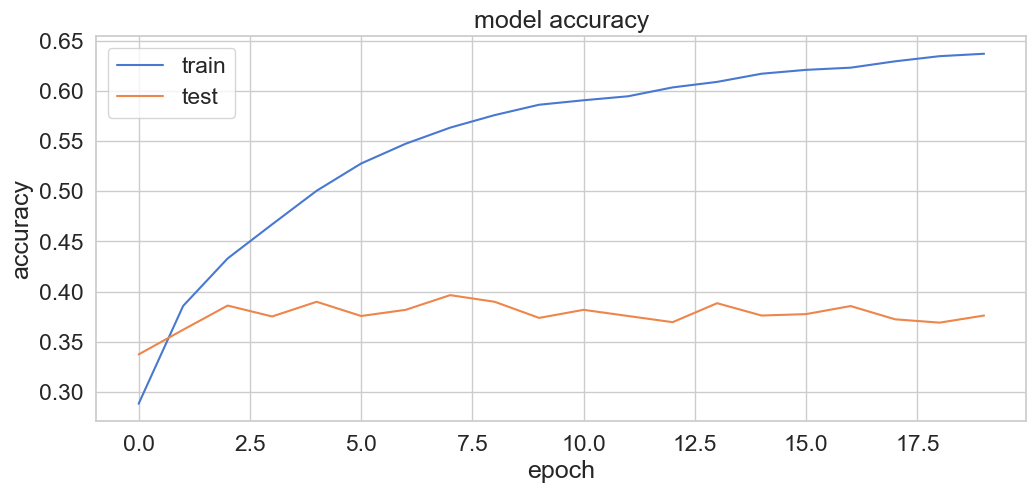

In [21]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

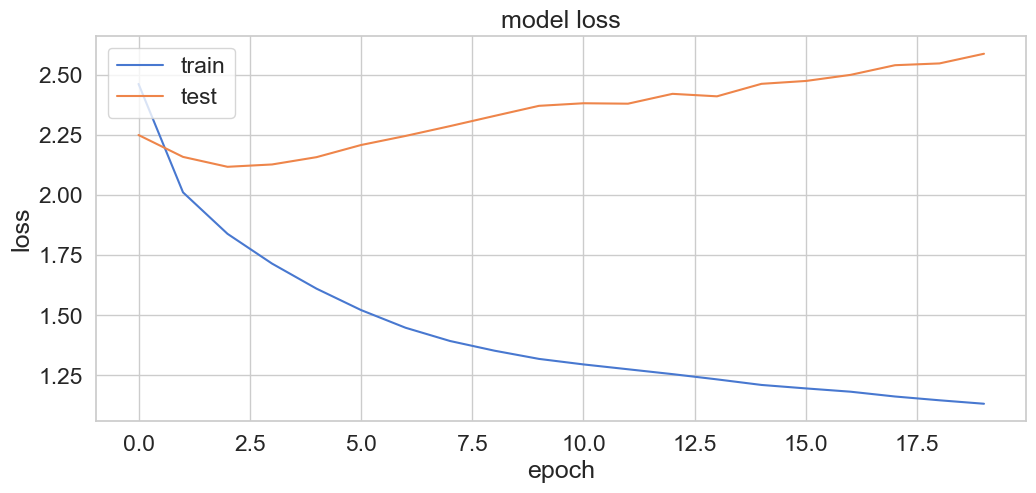

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

## Let’s put our model to the test

In [23]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [24]:
prepare_input("Біздің бірінші тексеретін мысалымыз бола".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [25]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

## This function allows us to ask our model what are the next n most probable characters. Isn’t it cool?

In [26]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [27]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [28]:
quotes = [
    "жаманшылыққа үйір бол сәлем, кер",
    "Әуелі - бек зор өкімет, жарлық қолында бар кі.",
    "Адамға хәлінше ихсанды болмақ - қарыз і",
    "Қазақтың жаманшылыққа үйір бола беретұғынының бір себебі - жұмысының жоқт",
    "Бәлки, дүниенің ғылымын білмей қалмақтық - бір үлкен зарарлы надандық, ол құранда сөгі"
]

In [29]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

жаманшылыққа үйір бол сәлем, кер
['  ', 'зиииннин ', '.иннсссаииллин ', ',исошөш ', 'т ']

әуелі - бек зор өкімет, жарлық қолында б
['ір ', 'ар ', 'ерген ', 'ұл ', 'олмайды. ']

адамға хәлінше ихсанды болмақ - қарыз і
[' усод.о ', 'кеіе,нң ', 'д. ', '.е ', 'іепіезе,а ']

қазақтың жаманшылыққа үйір бола беретұғы
['ны ', ', ', ' ғалым, ', 'л ', 'ран, ']

бәлки, дүниенің ғылымын білмей қалмақтық
[' бір ', ', ', 'тың ', '. ', 'қа ']



In [30]:
сәлем, қалайсың?

Object `қалайсың` not found.


In [31]:
кер

NameError: name 'кер' is not defined